In [11]:
import numpy as np
from rliable import library as rly
from rliable import metrics as rl_metrics
from rliable import plot_utils
from helpers import *

metric_names = [
    "Reward", 
    "Cost", 
    "Cost Regret"
]

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

df = load_ablation_data(load_ppo=True)

#sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_palette("colorblind")

mpl.rcParams["axes.titlesize"] = 11.
mpl.rcParams["axes.labelsize"] = 10.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['text.usetex'] = False
#mpl.rcParams['font.serif'] = ['cm']
mpl.rcParams['font.family'] = "serif"
#mpl.rcParams['font.serif'] = ['CMU']

df

,Metrics/EpRet,Metrics/EpCost,Metrics/EpLen,Metrics/EpCostRegret,Train/Epoch,Train/TotalSteps,Train/KL,Loss/Loss_reward_critic,Loss/Loss_cost_critic,Loss/Loss_actor,...,seed,algo,env,exp,Metrics/EpCumCostViolation,Train/div,Train/target_div,Misc/optim_case,Train/StopIter,Train/LR
22499,2875.437766,24.457000,1000.000000,156.250000,500,10000000,0.006303,3.681521,0.114410,-0.027855,...,seed-1000-2024-11-16-15-19-29,C-TRPO (no hyst.),SafetyHalfCheetahVelocity-v1,ablation,134.266000,0.007649,0.01,1.0,NaN,NaN
35551,3.483861,28.641000,1000.000000,991.750000,52,1040000,0.006041,0.020415,1.205537,-0.048665,...,seed-000-2024-11-16-17-53-16,C-TRPO (no hyst.),SafetyPointGoal1-v0,ablation,545.145280,0.006041,0.01,0.0,NaN,NaN
35552,5.319726,31.718000,1000.000000,1084.450000,53,1060000,0.005440,0.024515,0.963408,-0.034057,...,seed-000-2024-11-16-17-53-16,C-TRPO (no hyst.),SafetyPointGoal1-v0,ablation,551.863280,0.005440,0.01,0.0,NaN,NaN
35553,7.193985,39.300000,1000.000000,1350.300000,54,1080000,0.005355,0.025100,1.078762,-0.035651,...,seed-000-2024-11-16-17-53-16,C-TRPO (no hyst.),SafetyPointGoal1-v0,ablation,566.163280,0.005355,0.01,0.0,NaN,NaN
35554,7.527605,28.392000,1000.000000,826.100000,55,1100000,0.004891,0.020711,0.715297,-0.030835,...,seed-000-2024-11-16-17-53-16,C-TRPO (no hyst.),SafetyPointGoal1-v0,ablation,569.555280,0.004891,0.01,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,5665.656760,16.804762,938.989524,149.238095,496,9920000,0.004920,662.696157,1.210303,-0.085466,...,seed-4000-2024-09-04-15-00-21,NaN,SafetyHumanoidVelocity-v1,benchmark,203.904586,0.004942,0.01,1.0,NaN,NaN
119996,5677.851826,18.870909,939.825455,225.318182,497,9940000,0.001710,556.736877,1.685723,-0.073901,...,seed-4000-2024-09-04-15-00-21,NaN,SafetyHumanoidVelocity-v1,benchmark,203.904586,0.007546,0.01,1.0,NaN,NaN
119997,5578.639893,22.531429,922.922857,328.047619,498,9960000,0.001344,377.699952,1.644722,-0.160832,...,seed-4000-2024-09-04-15-00-21,NaN,SafetyHumanoidVelocity-v1,benchmark,203.904586,0.009369,0.01,1.0,NaN,NaN
119998,5509.021558,24.720000,912.399130,384.000000,499,9980000,0.001397,693.400342,1.287058,-0.057677,...,seed-4000-2024-09-04-15-00-21,NaN,SafetyHumanoidVelocity-v1,benchmark,203.904586,0.007905,0.01,1.0,NaN,NaN


## Aggregate Metrics (rliable)

In [21]:
normalized_score_dict_samples = {}

steps = np.array(range(1, 11))*1_000_000

for metric in metrics:
    normalized_score_dict_samples[metric] = {}
    for algo in ALGOS_ABLATION:
        normalized_score_dict_samples[metric][algo] = np.zeros((5, len(ENVS), 10))
        for i, env in enumerate(ENVS):
            for j, step in enumerate(steps):
                # display(df_filtered)
                df_filtered = df[df["env"] == env]
                if metric == "Metrics/EpRet":
                    norm = df_filtered[(df_filtered["algo"] == "PPO") & (df_filtered["Train/TotalSteps"] == 10_000_000)][metric].mean()
                elif metric == "Metrics/EpCost":
                    norm = 25.0
                else:  # "Metrics/EpCumCostViolation"
                    norm = df_filtered[(df_filtered["algo"] == "CPO (no hyst.)") & (df_filtered["Train/TotalSteps"] == 10_000_000)][metric].mean()
                data = np.array(df_filtered[(df_filtered["algo"] == algo) & (df_filtered["Train/TotalSteps"] == step)][metric])
                if not data.size == 0:
                    d = data / norm
                    normalized_score_dict_samples[metric][algo][:,i,j] = d
                else:
                    print(f"Warning: empty data for {algo}, {env}")

normalized_score_dict_samples

{'Metrics/EpRet': {'C-TRPO (no hyst.)': array([[[ 2.89310929e-01,  5.13003368e-01,  5.30257543e-01,
            5.54474912e-01,  5.65030914e-01,  5.66838375e-01,
            5.79081195e-01,  5.82814829e-01,  5.72593250e-01,
            5.72546755e-01],
          [ 1.99774091e-01,  2.69768899e-01,  3.19386265e-01,
            3.46054246e-01,  3.45010259e-01,  3.59507499e-01,
            3.68351269e-01,  3.69739039e-01,  3.82634777e-01,
            4.24572541e-01],
          [ 1.41711269e-01,  6.98580193e-01,  8.20175573e-01,
            8.02417878e-01,  8.33005266e-01,  8.29506615e-01,
            9.42406370e-01,  8.29959700e-01,  9.03495792e-01,
            8.79576564e-01],
          [ 7.90827717e-01,  8.30294073e-01,  8.97045689e-01,
            9.22448109e-01,  9.26897442e-01,  9.31845838e-01,
            9.33083000e-01,  9.34480961e-01,  9.15730019e-01,
            9.40416280e-01],
          [ 5.53187865e-02, -4.52283906e-02,  2.31656092e-02,
           -1.79880808e-03, -2.54925759e

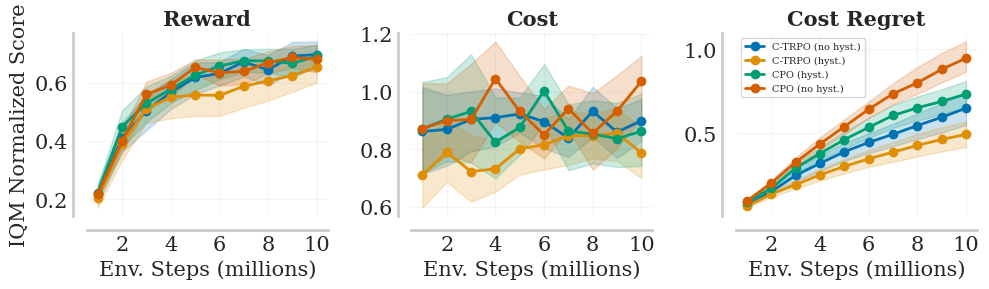

In [22]:

iqm_scores, iqm_cis = {}, {}

for metric, metric_name in zip(metrics, metric_names):
  iqm = lambda scores: np.array([rl_metrics.aggregate_iqm(scores[..., frame])
                                for frame in range(scores.shape[-1])])

  iqm_scores[metric_name], iqm_cis[metric_name] = rly.get_interval_estimates(
    normalized_score_dict_samples[metric], iqm, reps=50000)

_, axs = plt.subplots(1, 3, figsize=(10, 3))

for i, (metric_name, ax) in enumerate(zip(metric_names, axs)):
    plot_utils.plot_sample_efficiency_curve(
        np.array(range(1,11)), iqm_scores[metric_name], iqm_cis[metric_name], algorithms=ALGOS_ABLATION, ax=ax,
        xlabel=r'Env. Steps (millions)',
        ylabel="IQM Normalized Score" if i == 0 else "",
        labelsize=15,
        ticklabelsize=15,
        # legend=True if (i == 0) else False,
    )

    ax.set_title(metric_name, fontsize=15)
    ax.set_xticks([2, 4, 6, 8, 10])

plt.legend(prop={'size': 7})

plt.tight_layout()

plt.savefig(os.path.join("..", "graphics", f"ablation_samples.pdf"), dpi=600)